# Machine Learning for AI detection: Exploratory Data Analysis

In the previous notebook we cleaned and compiled the raw data into a single dataset consisting of over 24000 samples. We are now ready to explore the dataset using natural language processing (NLP) tools. Let's import the data:

In [1]:
import pandas as pd

samples = pd.read_csv('samples.csv')
samples

,text,source,topic,TTV split,label
0,I can't honestly believe that this is a sequel...,imdb,movie review,2.0,0
1,LL Cool J performed much better in this movie ...,imdb,movie review,0.0,0
2,It would be unwise to judge that that either n...,imdb,movie review,-1.0,0
3,20th Century Fox's ROAD HOUSE 1948) is not onl...,imdb,movie review,3.0,0
4,"I am a fan of Jess Franco's bizarre style, and...",imdb,movie review,-1.0,0
...,...,...,...,...,...
24175,The Louisville Cardinals men's soccer team is ...,wikipedia by GPT,Louisville Cardinals men's soccer,4.0,1
24176,"KFC Yum! Center, also known as the Yum! Center...",wikipedia by GPT,KFC Yum! Center,4.0,1
24177,The 2020–21 Louisville Cardinals men's basketb...,wikipedia by GPT,2020–21 Louisville Cardinals men's basketball ...,4.0,1
24178,Conte Forum is a multi-purpose indoor arena lo...,wikipedia by GPT,Conte Forum,4.0,1


## Tokenisation

Our first step in NLP will be to tokenise the data which, involves splitting a sample of text into individual units, which may either be whole words (word tokenization), or commonly occurring parts of words (subword tokenization). We can train a tokenizer from scratch from the data, or using a pre-trained tokenizer from a large language model (LLM). We will explore a number of different options: in addition to word tokenization, we will also look at subword tokenisation methods: byte pair encoding (BPE), wordpiece, sentencepiece, and the pre-trained tokenizers from three LLMs, GPT-2, Bert and Deberta.

In [2]:
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer
from tokenizers.models import BPE,WordPiece
from tokenizers.trainers import BpeTrainer,WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

/home/tommy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BPE_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
BPE_tokenizer.pre_tokenizer = Whitespace()
BPE_tokenizer.train_from_iterator(samples['text'], trainer=trainer)
BPE_tokenizer.save("../tokenizers/BPE.json")
tokenizer_BPE_trained = PreTrainedTokenizerFast(tokenizer_file="../tokenizers/BPE.json")

In [4]:
# create and train wordpiece tokenizer

wordpiece_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
trainer = WordPieceTrainer(special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"])
wordpiece_tokenizer.pre_tokenizer = Whitespace()
wordpiece_tokenizer.train_from_iterator(samples['text'], trainer=trainer)
wordpiece_tokenizer.save("../tokenizers/wordpiece.json")
tokenizer_wordpiece_trained = Tokenizer.from_file("../tokenizers/wordpiece.json")

In [5]:
import sentencepiece as spm

corpus_text = '\n\n'.join(samples['text'].tolist())
with open("corpus.txt", "w") as f:
    f.write(corpus_text)

spm.SentencePieceTrainer.Train('--input=corpus.txt --model_prefix=sentencepiece')
tokenizer_sentencepiece_trained = spm.SentencePieceProcessor()
tokenizer_sentencepiece_trained.Load('sentencepiece.model')

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=corpus.txt --model_prefix=sentencepiece
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: sentencepiece
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos

True

In [6]:
# import pre-trained tokenizers from LLMs

from transformers import GPT2Tokenizer, BertTokenizer, DebertaV2Tokenizer

tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2', max_length = 2048)
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-cased', max_length = 2048)
tokenizer_deberta_v3 = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base', max_length = 2048)

In [7]:
from nltk import word_tokenize

def tokenizer(text, name, cased=True):
    if cased is False:
        text = text.lower()
    if name == 'BPE':
        return [str(t) for t in tokenizer_BPE_trained(text)['input_ids']]
    elif name == 'wordpiece':
        return [str(t) for t in tokenizer_wordpiece_trained.encode(text).ids]
    elif name == 'sentencepiece':
        return [str(t) for t in tokenizer_sentencepiece_trained.encode_as_ids(text)]
    elif name == 'gpt-2':
        return [str(t) for t in tokenizer_gpt2(text)['input_ids']]
    elif name == 'bert':
        return [str(t) for t in tokenizer_bert(text)['input_ids']]
    elif name == 'deberta-v3':
        return [str(t) for t in tokenizer_deberta_v3(text)['input_ids']]
    elif name == 'word':
        return word_tokenize(text)
    else:
        print('Tokenizer name not recognized.')

def tokenizer_decode(tokenized, name):
    if name == 'BPE':
        return [tokenizer_BPE_trained.decode([int(t)]) for t in tokenized]
    elif name == 'wordpiece':
        return [tokenizer_wordpiece_trained.decode([int(t)]) for t in tokenized]
    elif name == 'sentencepiece':
        return [tokenizer_sentencepiece_trained.decode([int(t)]) for t in tokenized]
    elif name == 'gpt-2':
        return [tokenizer_gpt2.decode([int(t)]) for t in tokenized]
    elif name == 'bert':
        return [tokenizer_bert.decode([int(t)]) for t in tokenized]
    elif name == 'deberta-v3':
        return [tokenizer_deberta_v3.decode([int(t)]) for t in tokenized]
    else:
        print('Tokenizer name not recognized.')    

We can test our tokenisers on a few lines from Wind Rose's 2019 hit single 'Diggy diggy hole.' We'll first encode the data, then decode it to see how the tokenisers split words into subword tokens:

In [8]:
%%time

strg = "I am a dwarf and I'm digging a hole. Diggy diggy hole, diggy diggy hole..."
tokenizer_list = ['BPE', 'wordpiece', 'sentencepiece', 'gpt-2', 'bert', 'deberta-v3', 'word']

print(f'Text: {strg}')

for tokenizer_name in tokenizer_list:
    tokenized = tokenizer(strg, tokenizer_name)
    print(f'\tTokenized ({tokenizer_name}): {tokenized}')
    if tokenizer_name != 'word':
        print(f'\tDecoded: {tokenizer_decode(tokenized, tokenizer_name)}')

Text: I am a dwarf and I'm digging a hole. Diggy diggy hole, diggy diggy hole...
	Tokenized (BPE): ['45', '1969', '69', '19209', '74', '1937', '45', '11', '81', '23714', '69', '9903', '18', '10940', '3715', '3897', '3715', '9903', '16', '3897', '3715', '3897', '3715', '9903', '3190']


2024-05-27 16:22:41.149103: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 16:22:41.157841: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 16:22:41.204128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 16:22:42.386678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


	Decoded: ['I', 'am', 'a', 'dwar', 'f', 'and', 'I', "'", 'm', 'digging', 'a', 'hole', '.', 'Dig', 'gy', 'dig', 'gy', 'hole', ',', 'dig', 'gy', 'dig', 'gy', 'hole', '...']
	Tokenized (wordpiece): ['45', '3680', '69', '25843', '3323', '45', '11', '81', '26590', '69', '12402', '18', '12900', '4381', '5778', '4381', '12402', '16', '5778', '4381', '5778', '4381', '12402', '4595']
	Decoded: ['I', 'am', 'a', 'dwarf', 'and', 'I', "'", 'm', 'digging', 'a', 'hole', '.', 'Dig', '##gy', 'dig', '##gy', 'hole', ',', 'dig', '##gy', 'dig', '##gy', 'hole', '...']
	Tokenized (sentencepiece): ['12', '243', '10', '798', '2769', '161', '7', '12', '13', '35', '590', '109', '109', '15', '10', '14', '4099', '6', '1186', '109', '3063', '590', '109', '3063', '14', '4099', '3', '590', '109', '3063', '590', '109', '3063', '14', '4099', '480']
	Decoded: ['I', 'am', 'a', 'd', 'war', 'f', 'and', 'I', "'", 'm', 'di', 'g', 'g', 'ing', 'a', '', 'hole', '.', 'Di', 'g', 'gy', 'di', 'g', 'gy', '', 'hole', ',', 'di', 'g', 

We can now use our trained tokenisers to tokenise the samples:

In [9]:
%%time

from tqdm import tqdm

def tokenizer_key(name, cased):
    return f"{name}-{'cased' if cased else 'uncased'}"

for cased in [True, False]:
    for name in tqdm(tokenizer_list):
        samples[tokenizer_key(name, cased)] = samples['text'].apply(lambda x: tokenizer(x, name, cased))

samples

100%|█████████████████████████████████████████████| 7/7 [03:24<00:00, 29.16s/it]

CPU times: user 6min 30s, sys: 4.81 s, total: 6min 34s
Wall time: 6min 34s


,text,source,topic,TTV split,label,BPE-cased,wordpiece-cased,sentencepiece-cased,gpt-2-cased,bert-cased,deberta-v3-cased,word-cased,BPE-uncased,wordpiece-uncased,sentencepiece-uncased,gpt-2-uncased,bert-uncased,deberta-v3-uncased,word-uncased
0,I can't honestly believe that this is a sequel...,imdb,movie review,2.0,0,"[45, 2121, 11, 88, 5805, 3305, 1976, 2041, 193...","[45, 3520, 11, 88, 7426, 4802, 3365, 3425, 335...","[12, 60, 13, 18, 2709, 491, 17, 31, 16, 10, 23...","[40, 460, 470, 12698, 1975, 326, 428, 318, 257...","[101, 146, 1169, 112, 189, 12051, 2059, 1115, ...","[1, 273, 295, 280, 297, 6137, 770, 272, 291, 2...","[I, ca, n't, honestly, believe, that, this, is...","[77, 2121, 11, 88, 5805, 3305, 1976, 2041, 193...","[77, 3520, 11, 88, 7426, 4802, 3365, 3425, 335...","[207, 60, 13, 18, 2709, 491, 17, 31, 16, 10, 2...","[72, 460, 470, 12698, 1975, 326, 428, 318, 257...","[101, 178, 1169, 112, 189, 12051, 2059, 1115, ...","[1, 584, 295, 280, 297, 6137, 770, 272, 291, 2...","[i, ca, n't, honestly, believe, that, this, is..."
1,LL Cool J performed much better in this movie ...,imdb,movie review,0.0,0,"[11047, 18707, 46, 8133, 2549, 3094, 1926, 204...","[48, 1992, 26434, 46, 9916, 4007, 4575, 3330, ...","[574, 337, 679, 273, 1091, 4905, 211, 507, 11,...","[3069, 15226, 449, 6157, 881, 1365, 287, 428, ...","[101, 12427, 13297, 147, 1982, 1277, 1618, 110...","[1, 21965, 6906, 851, 2264, 400, 493, 267, 291...","[LL, Cool, J, performed, much, better, in, thi...","[2282, 6672, 78, 8133, 2549, 3094, 1926, 2041,...","[5020, 8437, 78, 9916, 4007, 4575, 3330, 3425,...","[14, 151, 3743, 2326, 4905, 211, 507, 11, 31, ...","[297, 3608, 474, 6157, 881, 1365, 287, 428, 38...","[101, 1325, 4348, 179, 1982, 1277, 1618, 1107,...","[1, 507, 436, 1570, 4402, 2264, 400, 493, 267,...","[ll, cool, j, performed, much, better, in, thi..."
2,It would be unwise to judge that that either n...,imdb,movie review,-1.0,0,"[2127, 2227, 1959, 1970, 4990, 1942, 10459, 19...","[3510, 3635, 3347, 6402, 3802, 3328, 9952, 336...","[63, 100, 42, 223, 3742, 9, 3416, 17, 17, 1016...","[1026, 561, 307, 555, 3083, 284, 5052, 326, 32...","[101, 1135, 1156, 1129, 8362, 15868, 1106, 394...","[1, 325, 338, 282, 44923, 264, 3128, 272, 272,...","[It, would, be, unwise, to, judge, that, that,...","[1941, 2227, 1959, 1970, 4990, 1942, 10459, 19...","[3355, 3635, 3347, 6402, 3802, 3328, 9952, 336...","[22, 100, 42, 223, 3742, 9, 3416, 17, 17, 1016...","[270, 561, 307, 555, 3083, 284, 5052, 326, 326...","[101, 1122, 1156, 1129, 8362, 15868, 1106, 394...","[1, 278, 338, 282, 44923, 264, 3128, 272, 272,...","[it, would, be, unwise, to, judge, that, that,..."
3,20th Century Fox's ROAD HOUSE 1948) is not onl...,imdb,movie review,3.0,0,"[4814, 16776, 10186, 11, 87, 8927, 5764, 11302...","[6390, 19153, 12317, 11, 87, 54, 1955, 14684, ...","[742, 91, 197, 304, 189, 45, 6250, 13, 4, 14, ...","[1238, 400, 13641, 5426, 338, 15107, 2885, 465...","[101, 3116, 5944, 3977, 112, 188, 155, 23579, ...","[1, 602, 474, 7178, 4224, 280, 268, 41119, 306...","[20th, Century, Fox, 's, ROAD, HOUSE, 1948, ),...","[4814, 2869, 21194, 11, 87, 4177, 2899, 10875,...","[6390, 4340, 25638, 11, 87, 7492, 4458, 12774,...","[742, 91, 413, 276, 2931, 13, 4, 2863, 483, 66...","[1238, 400, 4289, 21831, 338, 2975, 2156, 2179...","[101, 3116, 1432, 17594, 112, 188, 1812, 1402,...","[1, 602, 474, 1880, 16123, 280, 268, 1212, 669...","[20th, century, fox, 's, road, house, 1948, ),..."
4,"I am a fan of Jess Franco's bizarre style, and...",imdb,movie review,-1.0,0,"[45, 1969, 69, 4202, 1946, 11825, 14273, 11, 8...","[45, 3680, 69, 6069, 3327, 13596, 17012, 11, 8...","[12, 243, 10, 1298, 8, 2810, 4, 4, 4932, 335, ...","[40, 716, 257, 4336, 286, 12707, 22198, 338, 1...","[101, 146, 1821, 170, 5442, 1104, 12419, 9063,...","[1, 273, 481, 266, 2066, 265, 19554, 18813, 28...","[I, am, a, fan, of, Jess, Franco, 's, bizarre,...","[77, 1969, 69, 4202, 1946, 78, 2026, 17649, 21...","[77, 3680, 69, 6069, 3327, 11106, 12010, 342

## Visualising the tokeniser vocabularies

We are now ready to explore the vocabulary. Using the tokenized texts, we will perform a count of each token and plot their frequencies:

In [28]:
test = ['this is a sentence.', 'this is another sentence.']
test_tokenized = [tokenizer(s, 'BPE', cased) for s in test]
tf_vectorizer = TfidfVectorizer(preprocessor= lambda x:x, use_idf=False, norm='l1', tokenizer=lambda x:x, binary=True, token_pattern=None, lowercase=False)
vectorized = tf_vectorizer.fit_transform(test_tokenized)

In [29]:
test_tokenized

[['2041', '1939', '69', '11850', '18'],
 ['2041', '1939', '2917', '11850', '18']]

In [34]:
np.ravel(vectorized.mean(axis=0))

array([0.2, 0.2, 0.2, 0.2, 0.1, 0.1])

In [33]:
tf_vectorizer.get_feature_names_out()

array(['11850', '18', '1939', '2041', '2917', '69'], dtype=object)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import numpy as np

import gc

def get_term_frequencies(texts, vocabulary=None):
    if vocabulary is None:
        tf_vectorizer = TfidfVectorizer(preprocessor= lambda x:x, use_idf=False, norm='l1', tokenizer=lambda x:x, token_pattern=None, lowercase=False)
        vectorized = tf_vectorizer.fit_transform(texts).tocsr()
        vocabulary = tf_vectorizer.get_feature_names_out()
        vocab_size = len(vocabulary)
        print(f"Created new TF vectorizer with vocabulary size = {vocab_size}")

        mean_term_frequencies = np.ravel(vectorized.mean(axis=0))
        del(tf_vectorizer)
        gc.collect()

        term_indices_ranked_by_frequency_asc = np.argsort(mean_term_frequencies)
        term_indices_ranked_by_frequency = [term_indices_ranked_by_frequency_asc[vocab_size - 1 - i] for i in range(vocab_size)]
        terms_ranked_by_frequency = [vocabulary[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]

        return mean_term_frequencies, vocabulary, term_indices_ranked_by_frequency, terms_ranked_by_frequency, vocab_size

    else:
        tf_vectorizer = TfidfVectorizer(preprocessor= lambda x:x, use_idf=False, norm='l1', tokenizer=lambda x:x, token_pattern=None, vocabulary=vocabulary, lowercase=False)
        vectorized = tf_vectorizer.fit_transform(texts).tocsr()
    
        mean_term_frequencies = np.ravel(vectorized.mean(axis=0))
        del(tf_vectorizer)
        gc.collect()

        return mean_term_frequencies

Created new TF vectorizer with vocabulary size = 21790
Created new TF vectorizer with vocabulary size = 21648
Created new TF vectorizer with vocabulary size = 6599
Created new TF vectorizer with vocabulary size = 31728
Created new TF vectorizer with vocabulary size = 19570
Created new TF vectorizer with vocabulary size = 58776
Created new TF vectorizer with vocabulary size = 162626
Created new TF vectorizer with vocabulary size = 29553
Created new TF vectorizer with vocabulary size = 28294
Created new TF vectorizer with vocabulary size = 7998
Created new TF vectorizer with vocabulary size = 46832
Created new TF vectorizer with vocabulary size = 27749
Created new TF vectorizer with vocabulary size = 93777
Created new TF vectorizer with vocabulary size = 184698


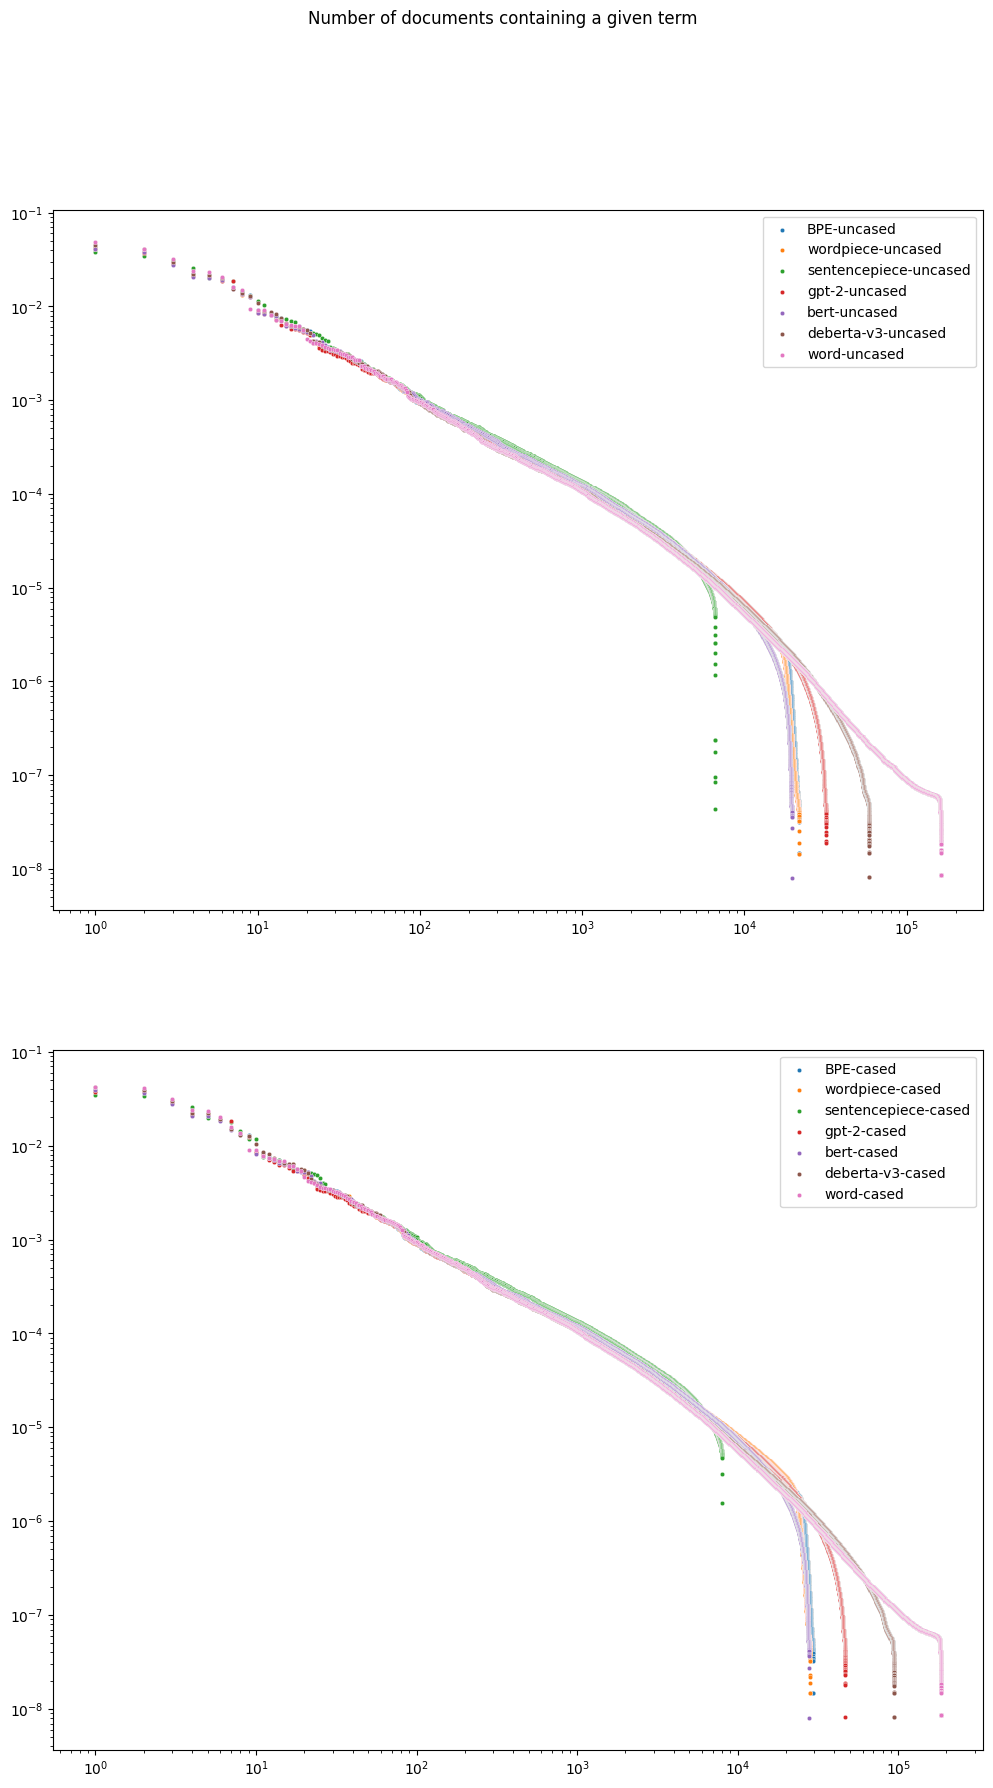

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize=(12,20))

for cased in (0,1):
    for name in tokenizer_list:
        mean_term_frequencies, vocabulary, term_indices_ranked_by_frequency, _, vocab_size = get_term_frequencies(samples[tokenizer_key(name, cased)])
        X = np.arange(len(mean_term_frequencies))
        Y = [mean_term_frequencies[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]
        sns.scatterplot(x=X, y=Y, ax = axes[cased], label=tokenizer_key(name,cased), s=10)

    axes[cased].set_xscale('log')
    axes[cased].set_yscale('log')
    axes[cased].set_xlabel('rank')
    axes[cased].set_ylabel('frequency')

fig.suptitle('Mean term frequencies')
plt.show()

In [43]:
name = 'BPE'
cased = True

term_frequencies_human, vocabulary, term_indices_ranked_by_frequency, _, vocab_size = get_term_frequencies(samples[samples['label']==0][tokenizer_key(name, cased)])
term_frequencies_AI = get_term_frequencies(samples[samples['label']==1][tokenizer_key(name, cased)], vocabulary=vocabulary)

Created new TF vectorizer with vocabulary size = 29365


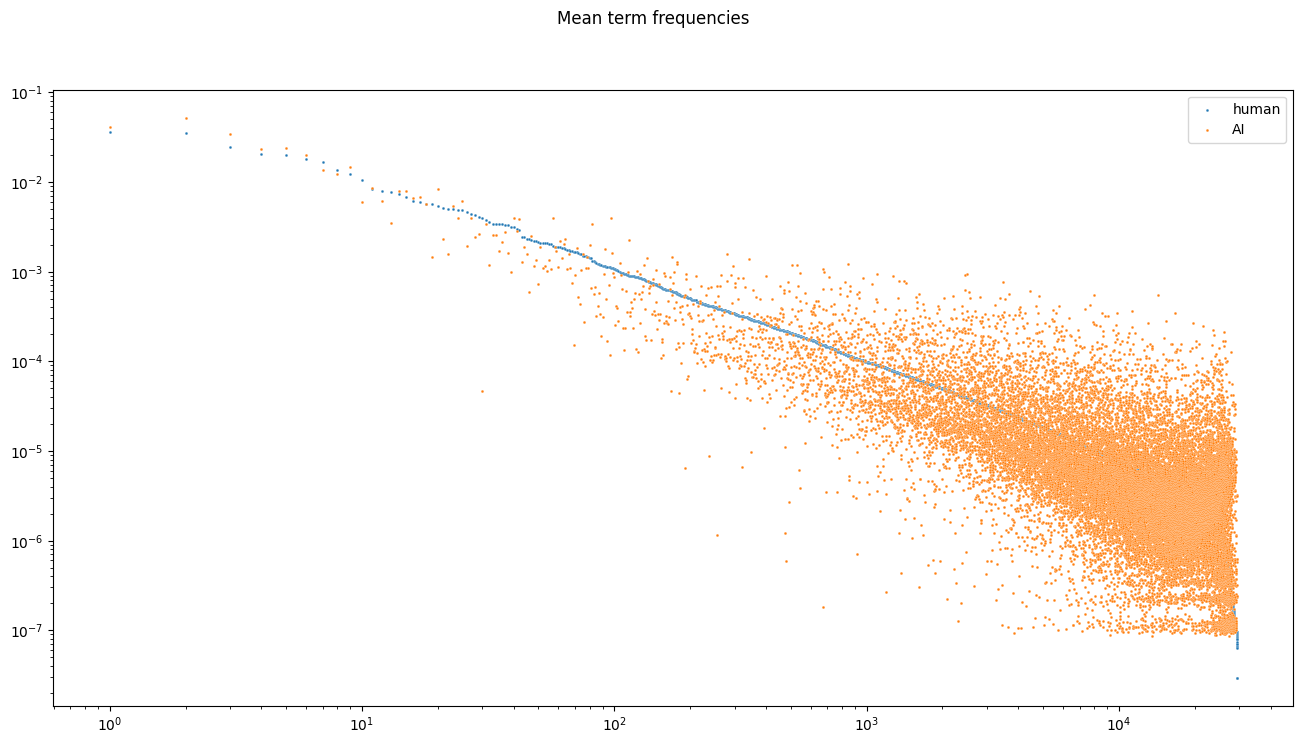

In [44]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(x=np.arange(vocab_size), y=[term_frequencies_human[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)], label='human', s=4)
sns.scatterplot(x=np.arange(vocab_size), y=[term_frequencies_AI[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)], label='AI', s=4)
ax.set_xscale('log')
ax.set_yscale('log')

fig.suptitle('Mean term frequencies')
plt.show()

In [45]:
token_frequency_data = pd.DataFrame()
token_frequency_data['term'] = [tokenizer_decode([vocabulary[term_indices_ranked_by_frequency[i]]], 'BPE') for i in range(vocab_size)]
token_frequency_data['frequency in human texts'] = [term_frequencies_human[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]
token_frequency_data['frequency in AI texts'] = [term_frequencies_AI[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]
token_frequency_data.head(20)

,term,frequency in human texts,frequency in AI texts
0,[the],0.037112,0.040510
1,[.],0.036304,0.041212
2,"[,]",0.035487,0.051934
3,[and],0.024748,0.034067
4,[of],0.020571,0.023177
5,[to],0.020118,0.023798
6,[a],0.018145,0.020136
7,[I],0.016761,0.013528
8,[in],0.013650,0.012158
9,['],0.012137,0.014531


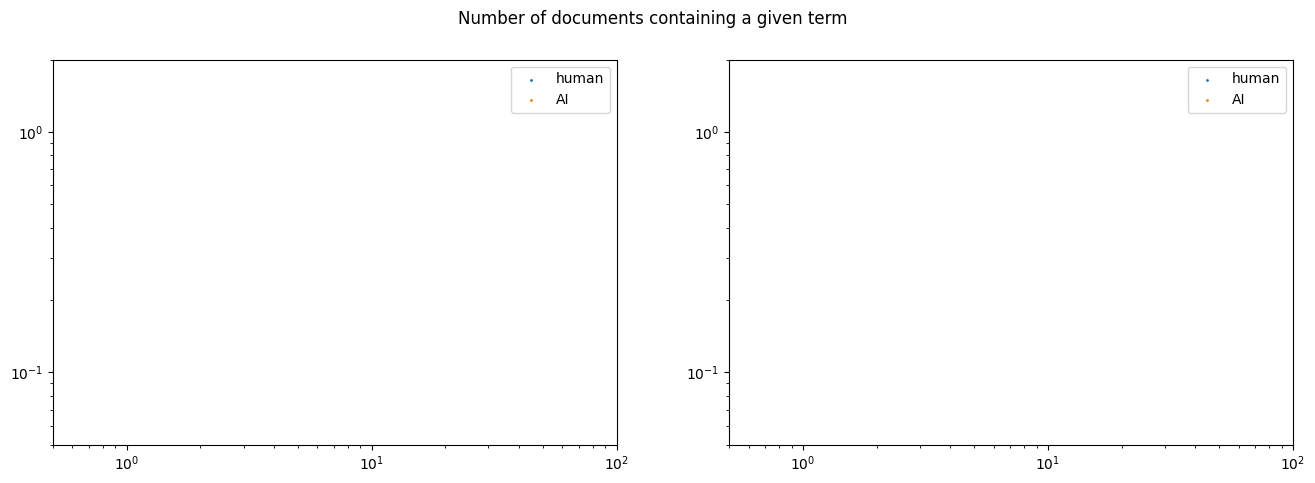

In [21]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

for cased in [0,1]:
    sns.scatterplot(x=np.arange(vocab_size), y=[term_frequencies_human[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)], ax = axes[cased], label='human', s=5)
    sns.scatterplot(x=np.arange(vocab_size), y=[term_frequencies_AI[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)], ax = axes[cased], label='AI', s=5)
    axes[cased].set_xscale('log')
    axes[cased].set_yscale('log')
    axes[cased].set_xlim(0.5,100)
    axes[cased].set_ylim(0.05,2)

fig.suptitle('Number of documents containing a given term')
plt.show()